# download data and copy to drive

In [14]:
!wget 'https://storage.googleapis.com/wandb_datasets/nature_12K.zip'
!unzip 'nature_12K.zip'

Streaming output truncated to the last 5000 lines.
  inflating: inaturalist_12K/train/Arachnida/1ac25349af662e85f577a31f64beca41.jpg  
  inflating: inaturalist_12K/train/Arachnida/117ef7f1812725f359500448a258e713.jpg  
  inflating: inaturalist_12K/train/Arachnida/6409254954c3b46d88d64f0bf4c632fa.jpg  
  inflating: inaturalist_12K/train/Arachnida/aaed865750bd52944658a7dd23366948.jpg  
  inflating: inaturalist_12K/train/Arachnida/460cc09ef510d400a4d47a836ddd45e6.jpg  
  inflating: inaturalist_12K/train/Arachnida/55c48c3afef0b745e53951284cdb2db4.jpg  
  inflating: inaturalist_12K/train/Arachnida/bff3daa961ee96a37ebe12dc0bcce504.jpg  
  inflating: inaturalist_12K/train/Arachnida/9082d4f2107bccf1f14d71c8944be607.jpg  
  inflating: inaturalist_12K/train/Arachnida/93d0130423d42f7c6228150eb95a2a93.jpg  
  inflating: inaturalist_12K/train/Arachnida/051aba6d7bc324bad76bd438ed3cc276.jpg  
  inflating: inaturalist_12K/train/Arachnida/67595af09c015c7753d5d4935677590f.jpg  
  inflating: inaturalist_

In [15]:
# !cp -av 'inaturalist_12K' 'drive/My Drive/DL_assignments/assignment2'

# code

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
%pip install wandb -q

import tensorflow 
import glob
import numpy as np
import math
import pandas as pd
from random import sample
import random
from bisect import bisect
from __future__ import print_function
import keras
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras import Input
from keras import backend as K
import wandb
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
random.seed(7)


     |████████████████████████████████| 2.1MB 18.4MB/s 
     |████████████████████████████████| 102kB 608kB/s 
     |████████████████████████████████| 133kB 55.8MB/s 
     |████████████████████████████████| 163kB 53.8MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 


In [17]:
img_size = 300
n_class = 10
# path = "drive/My Drive/DL_assignments/assignment2/inaturalist_12K/"
path = "inaturalist_12K/"


# part a 

In [64]:
# create model
def create_model(n_filters,dropout,batchnormalize):

  input_shape = (img_size,img_size,3)
  kernel_size = (3,3)
  pool_size = (3,3)
  lr = 0.0005
  activation = 'relu'
  dense_n = 256
  model = Sequential()

  model.add(Conv2D(n_filters[0], kernel_size=kernel_size,
                  activation=activation, kernel_regularizer=l2(lr), bias_regularizer=l2(lr),
                  input_shape=input_shape))
  if (batchnormalize) : model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=pool_size))

  model.add(Conv2D(n_filters[1], kernel_size=kernel_size,kernel_regularizer=l2(lr), bias_regularizer=l2(lr),
                  activation=activation))
  if (batchnormalize) : model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=pool_size))
  model.add(Dropout(dropout))

  model.add(Conv2D(n_filters[2], kernel_size=kernel_size,kernel_regularizer=l2(lr), bias_regularizer=l2(lr),
                  activation=activation))
  if (batchnormalize) : model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=pool_size))
  model.add(Dropout(dropout))


  model.add(Conv2D(n_filters[3], kernel_size=kernel_size,kernel_regularizer=l2(lr), bias_regularizer=l2(lr),
                  activation=activation, padding='same' ))
  if (batchnormalize) : model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=pool_size))
  model.add(Dropout(dropout))

  model.add(Conv2D(n_filters[4], kernel_size=kernel_size,kernel_regularizer=l2(lr), bias_regularizer=l2(lr),
                  activation=activation,padding='same'))
  if (batchnormalize) : model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=pool_size))
  model.add(Dropout(dropout))

 


  model.add(Flatten())

  model.add(Dense(dense_n, activation=activation,kernel_regularizer=l2(lr), bias_regularizer=l2(lr)))
  if (batchnormalize) : model.add(BatchNormalization())
  # model.add(Dropout(dropout))

  # model.add(Dense(256, activation='relu',kernel_regularizer=l2(lr), bias_regularizer=l2(lr)))
  # if (batchnormalize) : model.add(BatchNormalization())

  model.add(Dense(n_class, activation='softmax'))

  return model

## train

In [65]:
# train sweep
def train():
  run = wandb.init()
  c = run.config
  name = "f"+'_'.join(map(str,c.filters))+"_d_"+str(c.dropout)+"_bn_"+str(c.batchnormalize)+"_aug_"+str(c.aug)+"_bs_"+str(c.batch_size)
  run.name = name
  print(name)
 
  bs = c.batch_size
  epochs =15
  
  # create generator
  datagen = None
  if (c.aug):
    datagen = ImageDataGenerator(validation_split=0.1,rescale=1.0/255.0,rotation_range=90)
  else:
    datagen = ImageDataGenerator(validation_split=0.1,rescale=1.0/255.0)
  train = datagen.flow_from_directory(path+'train/',target_size=(img_size,img_size),
                                         seed=10,batch_size=bs,shuffle=True,class_mode="categorical",color_mode="rgb",subset="training")
  val = datagen.flow_from_directory(path+'train/',target_size=(img_size,img_size),
                                    seed=10,batch_size=bs,shuffle=True,class_mode="categorical",color_mode="rgb",subset="validation")
  
  labels = list(train.class_indices.keys())

  datagen_t = ImageDataGenerator(rescale=1.0/255.0)
  test = datagen_t.flow_from_directory(path+'val/',target_size=(img_size,img_size),
                                     seed=10,batch_size=1,shuffle=True,class_mode="categorical",color_mode="rgb")
  
  model = create_model(c.filters,c.dropout,c.batchnormalize)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

  model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
  
  model.fit(train,
   epochs = epochs,
	steps_per_epoch= len(train) ,
  validation_data=val,
  validation_steps=len(val),
  verbose = 1,
  callbacks=[WandbCallback(),es])
  
  loss,acc = model.evaluate(test,callbacks=[WandbCallback()])
  wandb.log({'test_acc' : round(acc*100,2),'test_loss' : round(loss,3)})
  
  
  return




In [ ]:
sweep_config={
    'method' : 'random' ,
    'metric' : { 'name' : 'val_accuracy' , 'goal' : 'maximize' } ,
    'parameters' : {
        'filters' : { 'values' : [[64,64,64,64,32],[64,64,32,32,16],[32,32,64,64,64]] },
        'dropout' : { 'values' : [0.2]},
        'batch_size' : {'values' : [64]},
        'batchnormalize' : {'values' : ['True' ,'False']},
        'aug' : {'values' : ['True' ,'False']}
    }
}


In [ ]:

sweepid = wandb.sweep(sweep_config,project="dl_a2",entity ="kkk")
wandb.agent(sweepid,train)

# without sweep


In [103]:
# for best model
def best_model():  
  bs = 64
  epochs = 15
  f = [32,32,64,64,64] 
  d = 0.2
  bn = True
  aug = True
  
  if (aug):
    datagen = ImageDataGenerator(validation_split=0.1,rescale=1.0/255.0,rotation_range=90)
  else:
    datagen = ImageDataGenerator(validation_split=0.1,rescale=1.0/255.0)

  train = datagen.flow_from_directory(path+'train/',target_size=(img_size,img_size),
                                         seed=10,batch_size=bs,shuffle=True,class_mode="categorical",color_mode="rgb",subset="training")
  val = datagen.flow_from_directory(path+'train/',target_size=(img_size,img_size),
                                    seed=10,batch_size=bs,shuffle=True,class_mode="categorical",color_mode="rgb",subset="validation")
  
  labels = list(train.class_indices.keys())

  datagen_t = ImageDataGenerator(rescale=1.0/255.0)
  test = datagen_t.flow_from_directory(path+'val/',target_size=(img_size,img_size),
                                     seed=10,batch_size=1,shuffle=True,class_mode="categorical",color_mode="rgb")
  
  # model = create_model(f,d,bn)
  # model.summary

  model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
  # print(999//128)

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

  model.fit(train,
   epochs = epochs,
	steps_per_epoch= len(train),
  validation_data=val,
  validation_steps=len(val),
  verbose = 1,callbacks=[es])
  
  loss,acc = model.evaluate(test)
  print(loss,acc)

  labels = val.class_indices

  return model , labels

In [ ]:
model,labels = best_model() # for 5 layers of conv

Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/15
141/141 [==============================] - 265s 2s/step - loss: 1.9155 - accuracy: 0.3696 - val_loss: 2.1131 - val_accuracy: 0.3534
Epoch 2/15
141/141 [==============================] - 261s 2s/step - loss: 1.8561 - accuracy: 0.3978 - val_loss: 2.1199 - val_accuracy: 0.3003
Epoch 3/15
 17/141 [==>...........................] - ETA: 3:27 - loss: 1.8697 - accuracy: 0.3730

In [68]:
model.save("drive/My Drive/DL_assignments/assignment2/best_model")

INFO:tensorflow:Assets written to: drive/My Drive/DL_assignments/assignment2/best_model/assets


In [54]:

# labels ={'Amphibia': 0, 'Animalia': 1, 'Arachnida': 2, 'Aves': 3, 'Fungi': 4, 'Insecta': 5, 'Mammalia': 6, 'Mollusca': 7, 'Plantae': 8, 'Reptilia': 9}

print(labels)



{'Amphibia': 0, 'Animalia': 1, 'Arachnida': 2, 'Aves': 3, 'Fungi': 4, 'Insecta': 5, 'Mammalia': 6, 'Mollusca': 7, 'Plantae': 8, 'Reptilia': 9}
['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


# q4


In [69]:
# load test data
def load_data():
  folders=glob.glob(path + "train/*")
  names = []
  ll = len(path)
  for i in folders:
    names.append(i[ll+6:])

  d = labels  

  n_of_images = 3
  folders=glob.glob(path + "val/*")
  test = []
  ytest = []
  for i in folders:
    temp = glob.glob(i+"/*")
    temp1 = [d[i[ll+4:]]] * n_of_images
    ytest += temp1
    for j in temp[:n_of_images]:
      img = cv2.imread(j)
      img = cv2.resize(img,(img_size,img_size))
      test.append(img)

  test = np.asarray(test).astype('float32')
  test = test / 255
  

  return  test ,ytest

In [70]:
x,y = load_data()


## b

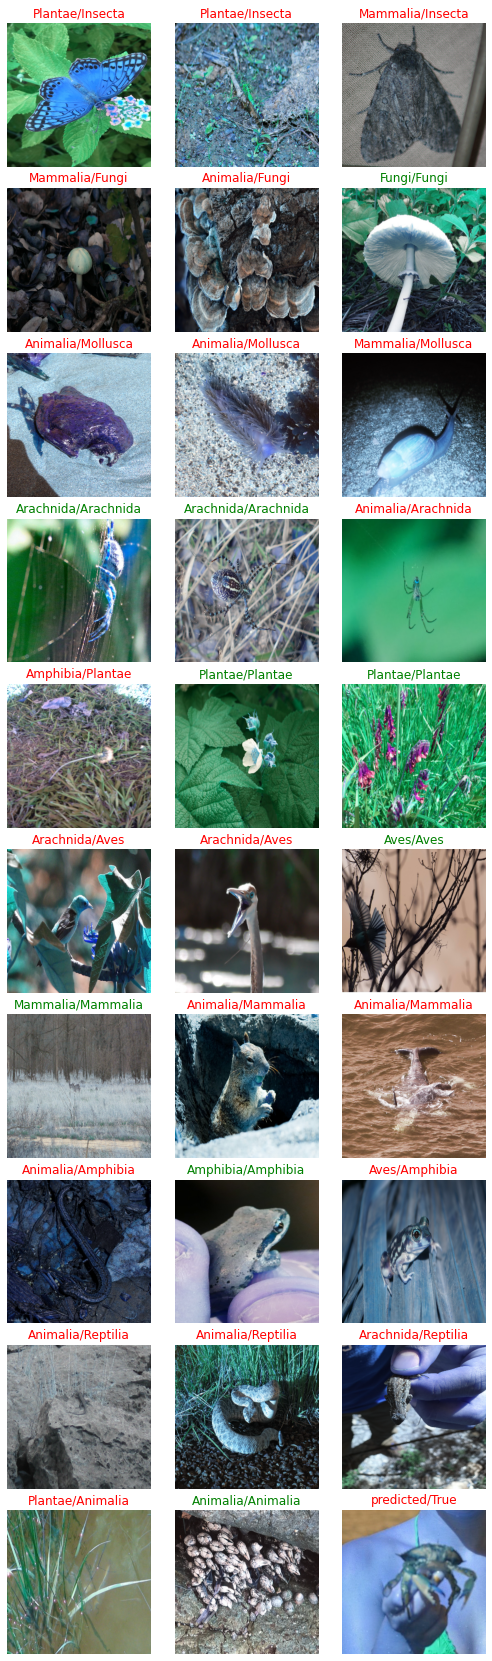

In [71]:
# plot the test images 
def plot_test(model,labels,x,y):
  # labels ={'Amphibia': 0, 'Animalia': 1, 'Arachnida': 2, 'Aves': 3, 'Fungi': 4, 'Insecta': 5, 'Mammalia': 6, 'Mollusca': 7, 'Plantae': 8, 'Reptilia': 9}
  label_list = list(labels)
  t = model.predict(x)
  t = t.argmax(axis=-1)
  # t1 = np.argmax(y,axis=-1)
  plt.figure(figsize=(9,30))
  plt.subplots_adjust(wspace=0, 
                    hspace=0.15)

  for i in range(len(x)):
    temp = label_list[t[i]]
    plt.subplot(10,3,i+1)
    plt.imshow(x[i])
    if(temp == label_list[y[i]]):
      c = 'g'
    else:
      c = 'r'
    plt.title(temp+"/"+label_list[y[i]],color = c)
    plt.axis("off")
  plt.title("predicted/True")

  plt.savefig("class.png" , dpi = 300)

plot_test(model,labels,x,y)

## c

In [ ]:
# plotting layer weights
# layer_w = model.layers[0].get_weights()
# print(layer_w[0].shape[-1])
# plt.figure(figsize=(20,20))
# for i in range(layer_w[0].shape[-1]):
#   plt.subplot(8,8,i+1)
#   plt.imshow(layer_w[0][:,:,:,i][:,:,:])
#   plt.axis("off")



(1, 298, 298, 32)


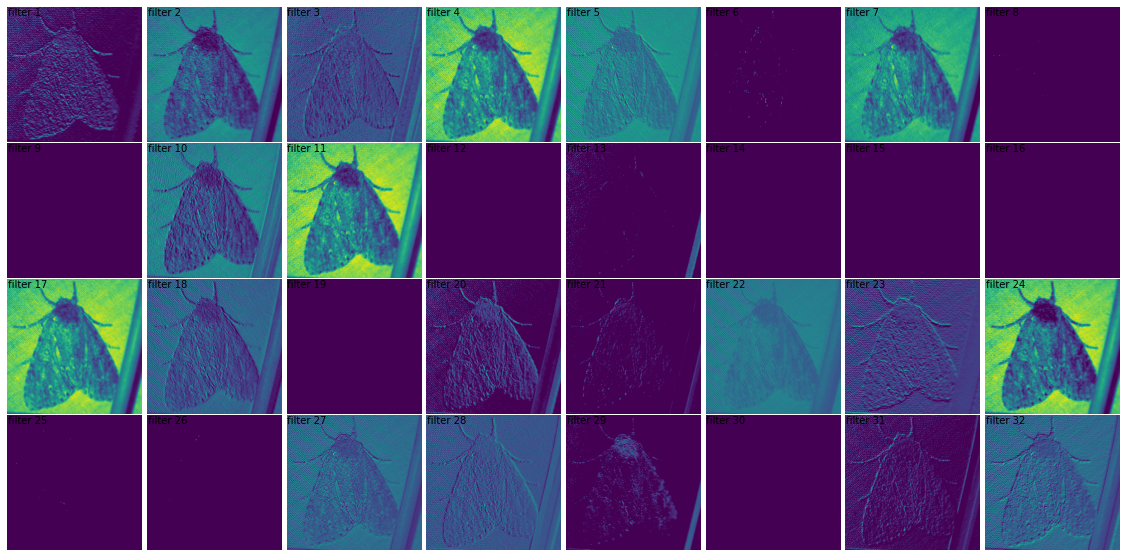

In [73]:
# plotting filters of first conv layer for random test image
from keras.models import Model
def plot_filters(img,model,layer_no = 1):
  layer_out = [i.output for i in model.layers]
  # m = Model(inputs = model.inputs , outputs = model.layers[0].output)
  m = Model(inputs = model.inputs , outputs = layer_out)
  # m.summary()
  feature_map = m.predict(np.reshape(img,(1,300,300,3)))
  l = layer_no # layer no
  print(np.shape(feature_map[l]))
  plt.figure(figsize=(20,20))
  plt.subplots_adjust(wspace=0.01, 
                    hspace=0.01)

  for i in range(np.shape(feature_map[l])[-1]):
    plt.subplot(8,8,i+1)
    plt.imshow(feature_map[l][0,:,:,i])
    plt.axis("off")
    plt.text(1,19,"filter " + str(i+1),horizontalalignment='left')
    # plt.title("filter " + str(i+1))
  plt.savefig("filter.png",dpi = 400)
plot_filters(x[2],model)

# q5

In [ ]:

from keras.applications import vgg16
from keras.applications.vgg16 import VGG16
from keras.applications import resnet50
from keras.applications.resnet50 import ResNet50 as RESNET50
from keras.applications import inception_v3
from keras.applications.inception_v3 import InceptionV3 as INCEPTION_V3
from keras.models import Model


In [ ]:
def load_pretrained_model(name,k = False,default_shape = False):
  p_model = None

  # last cov layer from below
  last_conv = {'resnet50' : 4 , 'vgg16' : 2 ,'inception_v3' : 12}

  # default input shape
  i_shape =  {'resnet50' : 224 , 'vgg16' : 224 ,'inception_v3' : 299}

  if (default_shape):
    p_model = globals()[name.upper()](weights='imagenet',include_top=False,input_tensor = Input(shape=(i_shape[name], i_shape[name], 3)))
  else:
    p_model = globals()[name.upper()](weights='imagenet',include_top=False,input_tensor = Input(shape=(img_size, img_size, 3)))

  for layer in p_model.layers:
	  layer.trainable = False
  
  if (k):
    for i in p_model.layers[-last_conv[name]:]:
      i.trainable = True

  # p_model.summary()
  flat = Flatten()(p_model.layers[-1].output)
  d1 = Dense(1024, activation='relu')(flat)
  # dr = Dropout(0.1)(d1)
  # d2 = Dense(1024, activation='relu')(dr)
  # dr = Dropout(0.1)(d1)
  output = Dense(10, activation='softmax')(d1)
  p_model = Model(inputs=p_model.inputs, outputs=output)
  # p_model.summary()
  return p_model
  

In [ ]:
def train_pretrain_model():
  global img_size
  
  run = wandb.init()
  c = run.config
  
  n = "m_"+c.model+"_ds_"+str(c.default_shape)+"_tlc_"+str(c.train_last_conv)+"_e_"+str(c.epoch)+"_aug_"+str(c.aug)+"_bs_"+str(c.batch_size)
  run.name = n
  print(n)
  name = c.model
 
  bs = c.batch_size
  epochs =c.epoch
  
  # create generator
  datagen = None
  if (c.aug):
    datagen = ImageDataGenerator(validation_split=0.1,preprocessing_function= exec(name+"."+"preprocess_input"),rotation_range=90)
  else:
    datagen = ImageDataGenerator(validation_split=0.1,preprocessing_function= exec(name+"."+"preprocess_input"))

  model = load_pretrained_model(name,k=c.train_last_conv,default_shape = c.default_shape)

  if (c.default_shape):
    img_size = model.layers[0].input.shape[1]

  # datagen = ImageDataGenerator(validation_split=0.1,preprocessing_function= exec(name+"."+"preprocess_input"))
  train = datagen.flow_from_directory(path+'train/',target_size=(img_size,img_size),
                                         seed=10,batch_size=bs,shuffle=True,class_mode="categorical",color_mode="rgb",subset="training")
  val = datagen.flow_from_directory(path+'train/',target_size=(img_size,img_size),
                                    seed=10,batch_size=bs,shuffle=True,class_mode="categorical",color_mode="rgb",subset="validation")
  
  labels = list(train.class_indices.keys())

  datagen_t = ImageDataGenerator(preprocessing_function= exec(name+"."+"preprocess_input"))
  test = datagen_t.flow_from_directory(path+'val/',target_size=(img_size,img_size),
                                     seed=10,batch_size=1,shuffle=True,class_mode="categorical",color_mode="rgb")
  
  
  # model.summary

  model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
  # print(999//128)

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

  model.fit(train,
   epochs = epochs,
	steps_per_epoch= len(train),
  validation_data=val,
  validation_steps=len(val),
  verbose = 1,callbacks=[WandbCallback(),es])
  
  loss,acc = model.evaluate(test,callbacks=[WandbCallback()])
  wandb.log({'test_acc' : round(acc*100,2),'test_loss' : round(loss,3)})
  # print(loss,acc)
  return

In [ ]:
sweep_config1={
    'method' : 'random' ,
    'metric' : { 'name' : 'val_accuracy' , 'goal' : 'maximize' } ,
    'parameters' : {
        'model' : {'values' : ['resnet50' , 'inception_v3' , 'vgg16']},
        'batch_size' : {'values' : [64,128]},
        'epoch' : {'values' : [3,5,7] },
        'default_shape' : {'values' : ['True']},
        'train_last_conv' : {'values' : ['True' ,'False']},
        'aug' : {'values' : ['True' ,'False']}
        
    }
}


In [ ]:

sweepid = wandb.sweep(sweep_config1,project="dl_a2",entity ="kkk")
wandb.agent(sweepid,train_pretrain_model)

Create sweep with ID: t3fay8l9
Sweep URL: https://wandb.ai/kkk/dl_a2/sweeps/t3fay8l9


wandb: Agent Starting Run: 2m9156zx with config:
wandb: 	aug: False
wandb: 	batch_size: 64
wandb: 	default_shape: True
wandb: 	epoch: 5
wandb: 	model: resnet50
wandb: 	train_last_conv: False


m_resnet50_ds_True_tlc_False_e_5_aug_False_bs_64
Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/5
141/141 [==============================] - ETA: 0s - loss: 22.0962 - accuracy: 0.3843

wandb: Ctrl + C detected. Stopping sweep.


## without sweep 

In [ ]:
def train_pretrain_model(name,ds = True):
  global img_size
  
  bs = 64
  epochs = 7

  model = load_pretrained_model(name,k=False,default_shape = False)

  if (ds):
    img_size = model.layers[0].input.shape[1]

  datagen = ImageDataGenerator(validation_split=0.1,preprocessing_function= exec(name+"."+"preprocess_input"))
  train = datagen.flow_from_directory(path+'train/',target_size=(img_size,img_size),
                                         seed=10,batch_size=bs,shuffle=True,class_mode="categorical",color_mode="rgb",subset="training")
  val = datagen.flow_from_directory(path+'train/',target_size=(img_size,img_size),
                                    seed=10,batch_size=bs,shuffle=True,class_mode="categorical",color_mode="rgb",subset="validation")
  
  labels = list(train.class_indices.keys())

  datagen_t = ImageDataGenerator(preprocessing_function= exec(name+"."+"preprocess_input"))
  test = datagen_t.flow_from_directory(path+'val/',target_size=(img_size,img_size),
                                     seed=10,batch_size=1,shuffle=True,class_mode="categorical",color_mode="rgb")
  
  
  # model.summary

  model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
  # print(999//128)

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

  model.fit(train,
   epochs = epochs,
	steps_per_epoch= len(train),
  validation_data=val,
  validation_steps=len(val),
  verbose = 1)
  
  loss,acc = model.evaluate(test)
  print(loss,acc)

In [ ]:
train_pretrain_model("resnet50")

[1, 10, 20, 30, 40, 60, 22, 33, 54, 48]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 3, 64)
(1, 3, 3, 64)
(1, 3, 3, 64)
(1, 3, 3, 64)
(1, 3, 3, 64)
(1, 3, 3, 64)
(1, 3, 3, 64)
(1, 3, 3, 64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 3, 64)
(1, 3, 3, 64)


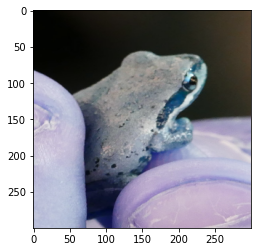

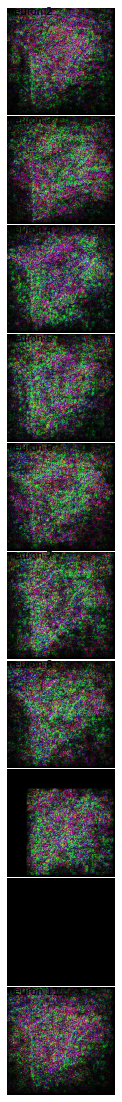

In [102]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def plot_guided_backprop():
  # Layer name to inspect
  layer_name = 'conv2d_35'
  neuron_index = [1,10,20,30,40,60,22,33,54,48] 
  print(neuron_index)
  # load model
  model = tf.keras.models.load_model("drive/My Drive/DL_assignments/assignment2/best_model")
  # model.summary()
  # Create a connection between the input and the target layer
  g_model = tf.keras.models.Model([model.inputs[0]], [model.get_layer(layer_name).output])
  l = 22
  input_img_data = np.reshape(x[l],(1,300,300,3))
  plt.imshow(x[l])
  layer_dict = [layer for layer in submodel.layers[1:] if hasattr(layer,'activation')]

  input_img_data = tf.Variable(tf.cast(input_img_data, tf.float32))

  # update gradient of relu
  @tf.custom_gradient
  def guidedRelu(x):
    def grad(dy):
      return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
    return tf.nn.relu(x), grad

  for layer in layer_dict:
    if layer.activation == tf.keras.activations.relu:
      layer.activation = guidedRelu


  plt.figure(figsize=(30,20))
  plt.subplots_adjust(wspace=0.01, 
                    hspace=0.01)

  # apply guided relu
  p = 1
  for k in neuron_index:
      with tf.GradientTape() as tape:
          outputs = g_model(input_img_data)
          print(np.shape(outputs))
          loss_value = tf.reduce_mean(outputs[:, :, :, k])
      grads = tape.gradient( loss_value, input_img_data)
      normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
      # input_img_data.assign_add(normalized_grads)
    
      plt.subplot(10,1,p)
      p+=1
      plt.imshow(normalized_grads[0],cmap='gray')
      plt.axis("off")
      plt.text(1,19,"neuron " + str(p),horizontalalignment='left')


In [ ]:
plt.imshow(img)

In [ ]:
tensorflow.Graph.gradient_override_map()

TypeError: ignored

In [ ]:
%tensorflow_version

Currently selected TF version: 2.x
Available versions:
* 1.x
* 2.x
